In [7]:
import numpy as np
import pandas as pd
import tqdm
import time
import pickle

from scipy.special import comb as binom
from lib import svm_proba
from lib import enm_proba_exact
from lib import enm_proba_apprx

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ERRNUM = 0
EPS = 1e-2

np.random.seed(8098)

In [3]:
def frac(a, b):
    if b:
        return a / b
    else:
        return 0

def plot(X, y, path):
    fig, ax = plt.subplots()
    ax.scatter(X[y == 0, 0], X[y == 0, 1], c="r")
    ax.scatter(X[y == 1, 0], X[y == 1, 1], c="g")

    for i in range(len(y)):
        ax.annotate(str(i), (X[i, 0], X[i, 1]))

    fig.savefig(path)
        
def upper(X, y, errnum, eps):
    n = y.sum() # ones number
    m = len(y) - y.sum() # zeros number
    mlt = 2 * binom(n + m, 2) / binom(n + m, n)
    return mlt

def lower(X, y, errnum, eps):
    n = y.sum() # ones number
    m = len(y) - y.sum() # zeros number
    mlt = (n + m) / binom(n + m, n)
    return mlt

def svm(X, y, errnum, eps):
    return frac(*svm_proba(X, y, errnum, eps))

def approx(X, y, errnum, eps):
    return frac(*enm_proba_apprx(X, y, errnum, eps))

def exact(X, y, errnum, eps):
    return frac(*enm_proba_exact(X, y))

In [4]:
def timer(func, *args, **kwargs):
    start = time.time()
    result = func(*args, **kwargs)
    end = time.time()
    return result, end - start

### Parameters

In [5]:
N_MIN, N_MAX = 2, 15
COV = np.array([
        [1, 0],
        [0, 1]
])

### Experiment

In [ ]:
bank = {
    "uprs": [],
    "lwrs": [],
    "svms": [],
    "aprx": [],
    "exct": []
}

map = {
    "uprs": upper,
    "lwrs": lower,
    "svms": svm,
    "aprx": approx,
    "exct": exact
}

for N0 in range(N_MIN, N_MAX + 1):
    for N1 in range(N0, N_MAX + 1):
        start = time.time()
        
        X0 = np.random.multivariate_normal(
            [0, 0],
            COV,
            size=N0
        )
        y0 = np.zeros(N0, dtype=int) + 0

        X1 = np.random.multivariate_normal(
            [0, 0],
            COV,
            size=N1
        )
        y1 = np.zeros(N1, dtype=int) + 1

        X = np.vstack([X0, X1], dtype=np.float32)
        y = np.concatenate([y0, y1], dtype=np.int32)

        for key, func in map.items():
            proba, duration = timer(func, X, y, ERRNUM, EPS)
            bank[key].append((N0, N1, proba, duration))

        print(N0, N1, time.time() - start)

        with open('data/data.pickle', 'wb') as handle:
            pickle.dump(bank, handle)

### Figures

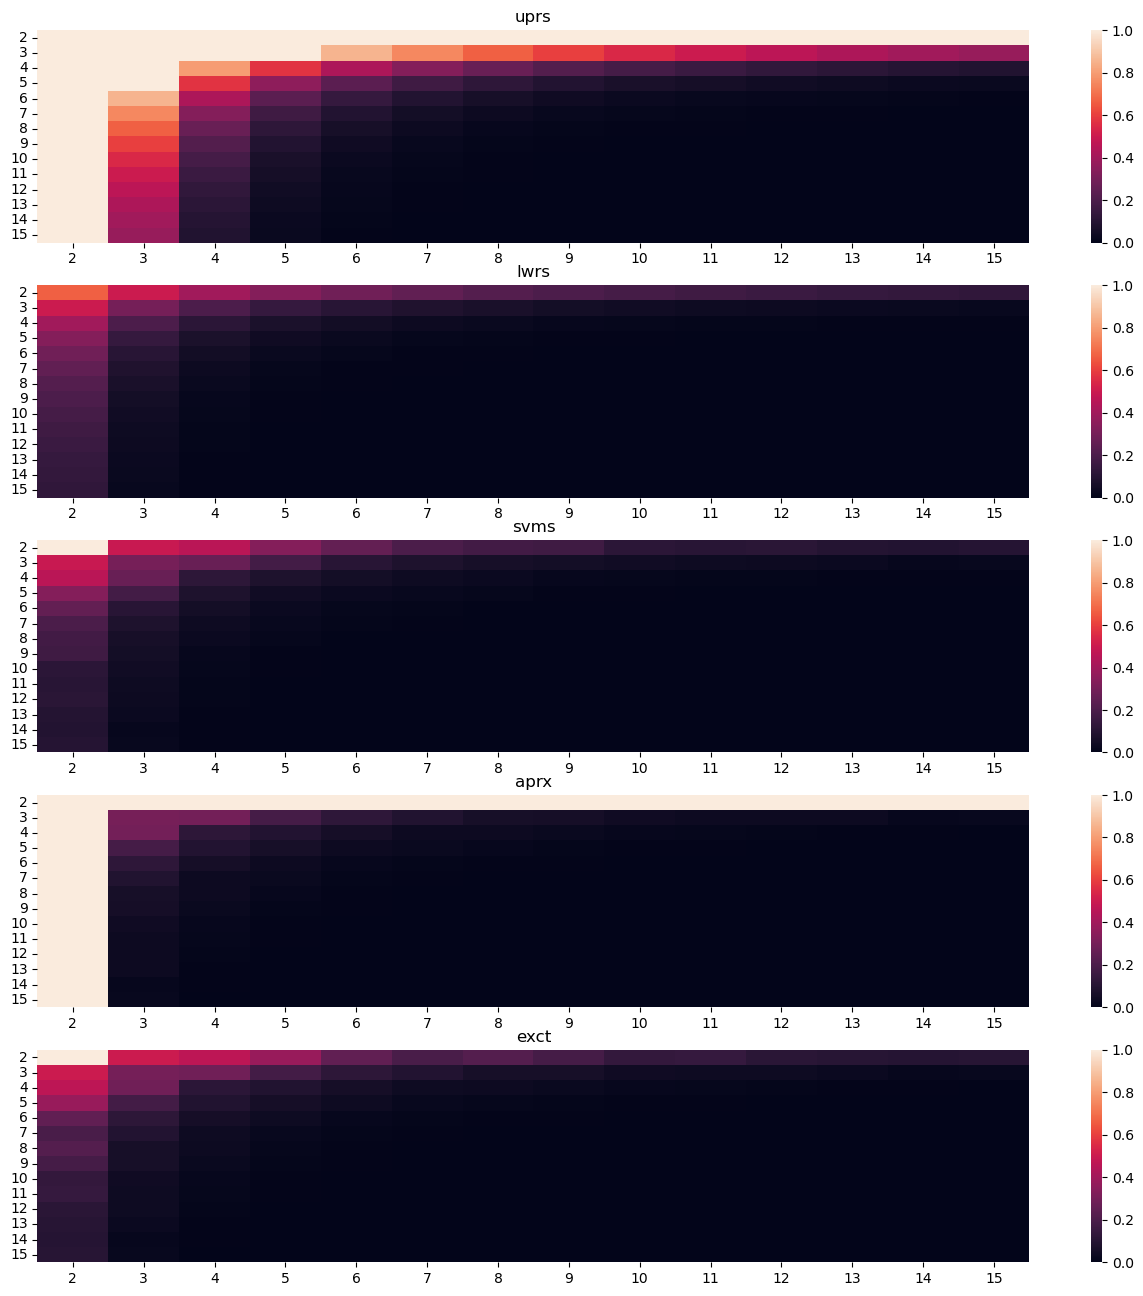

In [39]:
fig, ax = plt.subplots(nrows=len(bank), figsize=(16, 16))
for index, (key, lst) in enumerate(bank.items()):
    matrix = np.zeros((N_MAX - N_MIN + 1, N_MAX - N_MIN + 1))
    
    for exp in lst:
        i, j, proba, duration = exp
        i -= N_MIN
        j -= N_MIN

        matrix[i, j] = proba
        matrix[j, i] = proba

    matrix[matrix > 1] = 1.

    sns.heatmap(matrix, ax=ax[index], vmin=0, vmax=1)
    ax[index].set_xticklabels(range(N_MIN, N_MAX + 1))
    ax[index].set_yticklabels(range(N_MIN, N_MAX + 1))
    ax[index].set_title(key)

Text(0.5, 1.0, 'Time')

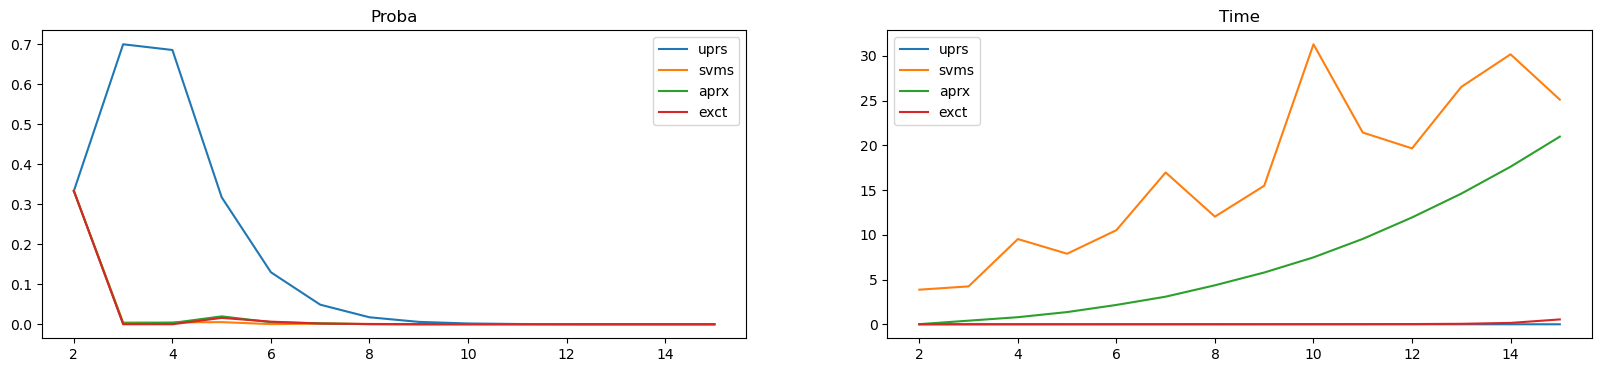

In [52]:
lwr_probas, lwr_durations = [], []
for exp in bank["lwrs"]:
    i, j, proba, duration = exp
    if i != j:
        continue

    if proba > 1:
        proba = 1
        
    lwr_probas.append(proba)
    lwr_durations.append(duration)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
for index, (key, lst) in enumerate(bank.items()):
    probas = []
    durations = []

    if key == "lwrs":
        continue

    for exp in lst:
        i, j, proba, duration = exp
        if i != j:
            continue

        if proba > 1:
            proba = 1
            
        probas.append(proba)
        durations.append(duration)

    ax[0].plot(range(N_MIN, N_MAX + 1), np.array(probas) - np.array(lwr_probas), label=key)
    ax[1].plot(range(N_MIN, N_MAX + 1), np.array(durations) - np.array(lwr_durations), label=key)

ax[0].legend()
ax[1].legend()
ax[0].set_title("Proba")
ax[1].set_title("Time")